# LSE ST451: Bayesian Machine Learning
## Author: Kostas Kalogeropoulos

## Week 7: Mixture Models

Topics covered 
 - Fitting Gaussian Mixture models using the EM algorithm
 - Obtaining information on soft allocation of individuals
 - Model Choice within the family of Gaussian Mixtures
 - Bayesian approach with overfitted mixtures

Standaer libraries will be used with the addition of two new ones from sklearn for the EM and Variational Bayes approach on Gaussian Mixtures

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

from sklearn import datasets
#The next two lines import the functions for the two things we will look into today
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

### Load the Iris dataset

The Iris Dataset. This data sets consists of 3 different types of irises' (Setosa, Versicolour, and Virginica) petal and sepal length, stored in a 150x4 numpy.ndarray. The rows being the samples and the columns being: Sepal Length, Sepal Width, Petal Length and Petal Width. The below plot uses the first two features.

In [2]:
iris = datasets.load_iris()
#next we import it into a pandas frame for convenience (not necessry)
pdiris = pd.DataFrame(iris.data, columns=iris.feature_names)
print(pdiris.shape)
pdiris.head()

(150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Plots 

Below we will see some 2d plots just to get a feel of the data. There appears to be some clustering but it is hard to infer the number of clusters of the 4d datasets from 2d plots. 

Text(0, 0.5, 'petal length (cm)')

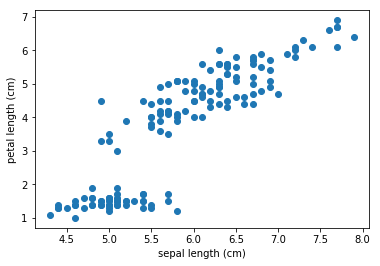

In [3]:
plt.plot(pdiris['sepal length (cm)'], pdiris['petal length (cm)'], 'o')
plt.xlabel('sepal length (cm)')
plt.ylabel('petal length (cm)')

Text(0, 0.5, 'petal length  (cm)')

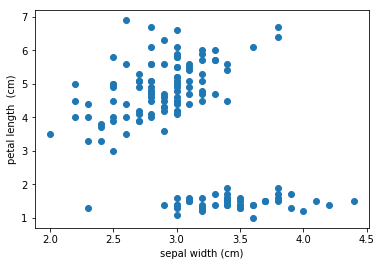

In [21]:
plt.plot(pdiris['sepal width (cm)'], pdiris['petal length (cm)'], 'o')
plt.xlabel('sepal width (cm)')
plt.ylabel('petal length  (cm)')

### Fitting GMMs using the EM algorithm

The code for doing so is given below. The '.fit' bit obtains the MLEs of means and covariances that can be viewed using '.means_' and '.covariances_'

We start by inspecting and visualisibg a 2-d dataset with only the 'sepal width (cm)' and 'petal width (cm)' variables. The full dataset is analysed afterwards

In [22]:
vars = ['sepal width (cm)','petal length (cm)']
gmm = GaussianMixture(n_components=2)
gmm.fit(pdiris[vars])
print(gmm.means_)
print('\n')
print(gmm.covariances_)

[[3.42806577 1.46200936]
 [2.87198343 4.90589429]]


[[[0.1407512  0.01145405]
  [0.01145405 0.02955718]]

 [[0.10962331 0.14142363]
  [0.14142363 0.67512617]]]


### Soft allocation of individuals to clusters

GMM method does not necesarily allocates individuals with certainty but with probabilities.

Adding the probabilities can give as an ideas of how many people each cluster has.

In [23]:
probs = gmm.predict_proba(pdiris[vars])
print(np.sum(probs,axis=0))
print(probs[21:50].round(3))

[ 49.99706629 100.00293371]
[[1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.997 0.003]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]]


### Model Search

We need to fit models wiht different numbers of cluster and different type of covariance matrices to identify the best one. This is done via the BIC (the smaller the better in this case)

Types of covariance matrices:
 - spherical: each cluster k has covariance $\sigma^2_k I$
 - tied: full covariance matrix but the same across clusters
 - diag: diagonal covariance matrix, different for each cluster
 - full: full covariance matrix, different for each cluster
 

In [12]:
lowest_bic = np.infty

#Consider k=1,...,6 and four types of covariance matrix
n_components_range = range(1, 9)
cv_types = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(n_components_range),len(cv_types))) #matrix to store the BICs
j = -1
for cv_type in cv_types:
    j = j+1
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(pdiris)
        bicij = gmm.bic(pdiris)  #get the BIC 
        bic[n_components-1,j] = bicij
        #the code below keeps track of the model with the lowest BIC
        if bicij < lowest_bic:
            lowest_bic = bicij
            best_gmm = gmm
print(lowest_bic)
bic = pd.DataFrame(bic,columns = cv_types,index=n_components_range)
bic

574.0178327207459


,spherical,tied,diag,full
1,1804.085438,829.978155,1522.120153,829.978155
2,1012.235180,688.097220,857.551494,574.017833
3,853.809341,633.825288,744.633209,580.859425
4,814.336382,618.038221,705.122661,625.441241
5,747.009336,629.891501,701.149160,681.458987
6,754.324569,616.437688,698.241954,729.078984
7,722.887534,640.768584,728.946261,774.372045
8,738.295201,639.359438,711.987570,810.014262


In [13]:
print(best_gmm.means_)
print('\n')
print(best_gmm.covariances_)

[[6.26198886 2.87199642 4.90597719 1.67599129]
 [5.00600639 3.4280142  1.46200203 0.24599932]]


[[[0.43497387 0.12094155 0.44886533 0.16550229]
  [0.12094155 0.10961836 0.14138002 0.07923243]
  [0.44886533 0.14138002 0.67484296 0.2858736 ]
  [0.16550229 0.07923243 0.2858736  0.17863587]]

 [[0.12176331 0.09722605 0.01602717 0.01012447]
  [0.09722605 0.14080279 0.01146185 0.00911288]
  [0.01602717 0.01146185 0.02955704 0.00594818]
  [0.01012447 0.00911288 0.00594818 0.0108851 ]]]


### Activity 1

Repeat the analysis using only two of the four variables. Do we get a different conclusion on the number of clusters? 

Put your code below

In [20]:
lowest_bic = np.infty
vars = ['sepal length (cm)','petal length (cm)']

#Consider k=1,...,6 and four types of covariance matrix
n_components_range = range(1, 9)
cv_types = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(n_components_range),len(cv_types))) #matrix to store the BICs
j = -1
for cv_type in cv_types:
    j = j+1
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(pdiris[vars])
        bicij = gmm.bic(pdiris[vars])  #get the BIC 
        bic[n_components-1,j] = bicij
        #the code below keeps track of the model with the lowest BIC
        if bicij < lowest_bic:
            lowest_bic = bicij
            best_gmm = gmm
print(lowest_bic)
bic = pd.DataFrame(bic,columns = cv_types,index=n_components_range)
bic

573.8045600818292


,spherical,tied,diag,full
1,1057.100089,774.267705,983.296180,774.267705
2,701.430643,658.183568,683.455604,573.804560
3,665.136877,623.873385,654.635944,586.121097
4,636.563762,628.286329,626.991782,618.307767
5,637.248491,644.165536,633.534743,636.914949
6,651.399846,630.996946,642.433807,658.341713
7,653.392981,625.684652,659.052029,671.673215
8,651.602125,630.393394,686.247891,694.997563


In [ ]:
print(best_gmm.means_)
print('\n')
print(best_gmm.covariances_)

### Simulate data to test the method

So far we have been looking at a dataset where we are not sure about the 'true' number of clusters and type of covariance matrix.

In what follows we will simulate data from a Gaussian mixture with three components and spherical covariance matrix.

(600, 2)
[[-5.98898996  2.96813929]
 [-0.05362383  0.10657981]
 [ 3.30233239 -3.6440943 ]]
[0.15235684 0.95059212 9.1307105 ]


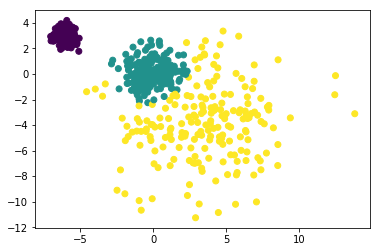

In [24]:
# Number of samples per component
n_samples = 200
np.random.seed(5)

# Generate random sample, three components 1.mean (0,0) cov=1I, 2. mean (-6, 3) cov=.49I and
# 3. mean (3, -4) cov=4I
C = np.array([[0., -0.1], [1.7, .4]])
X = np.r_[np.random.randn(n_samples, 2), 
          .4 * np.random.randn(n_samples, 2) + np.array([-6, 3]), 
         3* np.random.randn(n_samples, 2) + np.array([3, -4])] 
print(X.shape)
gmm = GaussianMixture(n_components=3,covariance_type='spherical')
gmm.fit(X)
print(gmm.means_)
print(gmm.covariances_)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels)                                                     

### Test the method

Below we repeat the previous model search procedure to the data contained in X. We would like to test whethere the optimal models will indeed be the one with three components and spherical covariance

In [25]:
lowest_bic = np.infty
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
bic = np.zeros((len(n_components_range),len(cv_types)))
j = -1
for cv_type in cv_types:
    j = j+1
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bicij = gmm.bic(X)
        bic[n_components-1,j] = bicij
        if bicij < lowest_bic:
            lowest_bic = bicij
            best_gmm = gmm
print(lowest_bic)
bic = pd.DataFrame(bic,columns = cv_types,index=n_components_range)
bic

4814.519577703146


,spherical,tied,diag,full
1,6652.518333,6184.196737,6615.417378,6184.196737
2,5157.619530,6153.896995,5168.246038,5122.187996
3,4814.519578,5836.906756,4830.568268,4849.482297
4,4841.296848,5716.420978,4864.335123,4888.803861
5,4868.646465,5580.302419,4893.487359,4917.581418
6,4892.547636,5623.645161,4911.773335,4952.906536


### Activity 2

Conduct another simulation experiment generating data from a Gaussian mixture. Choose your own number of components, means and covariances.

Put your code below

### Overfitted Mixtures

Now we will explore what happens when we fit a model with more components than the ones in the data. 

In [26]:
gmm = GaussianMixture(n_components=6,covariance_type='spherical')
gmm.fit(X)
probs = gmm.predict_proba(X)
results = np.sum(probs,axis=0)
results = pd.DataFrame(results.round(0), columns = ['# of individuals'], index=range(1,7))
results

,# of individuals
1,35.0
2,200.0
3,203.0
4,56.0
5,38.0
6,68.0


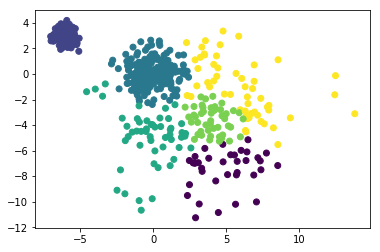

In [27]:
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels) 

## Bayesian Gaussian Mixture models

We will also apply the fully Bayesian model to the same data with a Dirichlet prior on the cluster probabilities with a low hyperparameter (weight_concentration_prior) of 0.01. This choice is going to penalise redundant clusters by not allocating individuals to them unless it is necessaray 

In [28]:
Bgmm = BayesianGaussianMixture(n_components=6,covariance_type='full',
                               weight_concentration_prior=0.01, max_iter = 200)
Bgmm.fit(X)
probs = Bgmm.predict_proba(X)
results = np.sum(probs,axis=0)
results = pd.DataFrame(results.round(0), columns = ['# of individuals'], index=range(1,7))
results

,# of individuals
1,200.0
2,0.0
3,206.0
4,0.0
5,0.0
6,194.0


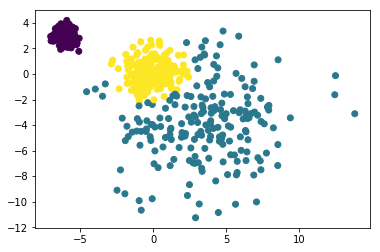

In [29]:
labels = Bgmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels)

### Activity 3

Fit the fully Bayesian approach to the Iris dataset and check the resulting number of clusters.

Put your code below